# import library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

# Model LogisticRegression Implementation

In [2]:
class LogisticRegression:
    def __init__(self, lr = 0.01, n_epochs = 100, batch_size = 1, shuffle = False, threshold = 0.5, w = None, random_state = 42, verbose = 1):
        self.lr = lr # learning rate - speed of learning of model
        self.n_epochs = n_epochs # the number of learning
        self.batch_size = batch_size # the number of sample select from train set to training
        self.shuffle = shuffle # Do you want swap all sample in training of each epoch?
        self.threshold = threshold # threshold to inference of model which decision the class of sample
        self.train_Losses = [] # list loss-train_set of model of each epoch
        self.train_accuracies = [] # list accuracy-train_set of model of each epoch
        self.val_Losses = [] # list loss-val_set of model of each epoch
        self.val_accuracies = [] # list accuracy-val_set of model of each epoch
        self.Nsamples = None # the number of samples which has in training set
        self.Nfeatures  = None # the number of feature which has in training set
        self.w = w # matrix weight of models
        np.random.seed(random_state)
        if verbose == 0 or verbose == 1 or verbose == 2:
            self.verbose = verbose # the parameter allows type of the print in training process
        else: 
            raise ValueError("verbose must be 0 - don't print\n1 - print the process of batch in each epoch\n2 - print the proccess of epoch ")
        # Số batch sẽ được lấy ra huấn luyện dựa trên batch_size và số sample huấn luyện
        self.batch_number = None

        # Tập validation
        self.X_val, self.y_val = None, None
        # 
    
    # ----------------------------------------------------------------------------------------------
    # function to check dimensional of matrix 
    def CheckDim(self,X):
        if X.ndim == 1:
            raise ValueError("X must be 2 - Dimensional")
        return 1
        
    #-----------------------------------------------------------------------------------------------
    # function to add feature have value = 1 on head each sample
    def addFeature1(self,X):
        if self.CheckDim(X):
            if X.shape[1] == self.Nfeatures +1: return X
            feature1 = np.ones((X.shape[0],1))
            return np.concatenate((feature1,X), axis = 1)

    #----------------------------------------------------------------------------------------------
    # activate function - sigmoid function
    def sigmoid(self,z):
        return 1/(1+np.e**(-z))
    
    # ----------------------------------------------------------------------------------------------
    # function to compute y_pred
    def predict_prob(self,X):
        X = self.addFeature1(X)
        # compute z
        z = X@self.w
        return self.sigmoid(z)

    # -----------------------------------------------------------------------------------------------
    # function to desion the class of sample - inference of model
    def predict(self,X):
        y_prob = self.predict_prob(X)
        return np.where(y_prob>self.threshold, 1, 0)

    # -----------------------------------------------------------------------------------------------
    # function to compute Loss
    def Compute_Loss(self, y, y_prob):
        # Giới hạn giá trị max_min của y_prob để tránh việc không biểu diễn được underflow, overflow
        y_prob = np.clip(y_prob,1e-07,1 - 1e-07)
        BCE = np.mean(-y*np.log(y_prob) - (1-y)*np.log(1-y_prob))
        return BCE

    # -----------------------------------------------------------------------------------------------
    # function to compute derivative dL/dw
    def dL_dw(self,X, y, y_prob):
        return X.T@(y_prob - y)*(1/X.shape[0])

    # ----------------------------------------------------------------------------------------------
    # function to train model
    def fit(self, X, y,X_val=None,y_val=None):
        if self.CheckDim(X):
            self.Nsamples, self.Nfeatures = X.shape
        # add features have value = 1 for head each sample
        X = self.addFeature1(X)
        # reshape array y -> matrix (m,1)
        y = y.reshape(-1,1)
        if self.w is None:
            self.w = np.random.uniform(low=-1, high=1, size=(self.Nfeatures +1 ,1))
        else: self.CheckDim(self.w)
        data_train = np.concatenate((X,y), axis = 1) 
        for epoch in range(self.n_epochs):
            if self.shuffle: np.random.shuffle(data_train)
            train_loss_epoch = [] # loss-train of 1 epoch
            train_accuracy_epoch = [] # accuracy-train of 1 epoch
            self.batch_number = (self.Nsamples//self.batch_size) +1 if self.Nsamples % self.batch_size != 0 else self.Nsamples//self.batch_size
            batch_cout = 1 # variable to cout the batch number of epoch
            for i in range(0, self.Nsamples, self.batch_size):
                batch = data_train[i:i+self.batch_size]
                X_train, y_train = batch[:,:-1], batch[:,-1].reshape(-1,1)
                y_prob = self.predict_prob(X_train)
                # decision the class
                y_pred = self.predict(X_train)
                # accuracy-train of 1 batch
                train_accuracy = np.mean(y_pred == y_train)
                train_accuracy_epoch.append(train_accuracy)
                # loss-train of 1 batch 
                train_loss = self.Compute_Loss(y_train,y_prob)
                train_loss_epoch.append(train_loss)
                if self.verbose == 1:
                    if batch_cout == 1:
                        print(f"Epoch {epoch +1:<3}/{self.n_epochs}")
                    print(f"==> [{batch_cout}/{self.batch_number:<3}] =========== Loss-Train = {train_loss_epoch[-1]:<10.4f} ============ Accuracy-Train = {train_accuracy_epoch[-1]:<10.4f}")
                # compute derivative 
                dL_dw = self.dL_dw(X_train,y_train, y_prob)
                # update weight 
                self.w -= self.lr*dL_dw
                batch_cout +=1
            if X_val is not None and y_val is not None:
                self.X_val = self.addFeature1(X_val)
                self.y_val = y_val.reshape(-1,1)
                y_val_prob = self.predict_prob(self.X_val)
                y_val_pred = self.predict(self.X_val)
                val_Loss = self.Compute_Loss(self.y_val, y_val_prob)
                val_acc = np.mean(y_val_pred == self.y_val)
                self.val_Losses.append(val_Loss)
                self.val_accuracies.append(val_acc)
            self.train_Losses.append(sum(train_loss_epoch)/len(train_loss_epoch))
            self.train_accuracies.append(sum(train_accuracy_epoch)/len(train_accuracy_epoch))
            if self.verbose == 2:
                val_loss_show = self.val_Losses[-1].item() if len(self.val_Losses) else float('nan')
                val_acc_show = self.val_accuracies[-1].item() if len(self.val_accuracies) else float('nan')
                print(f"Epoch {epoch+1:<3}/{self.n_epochs} ========== Loss-Train = {self.train_Losses[-1].item():<12.4f}==============  Accuracy-Train = {self.train_accuracies[-1].item():<10.4f}========== Loss-Val = {val_loss_show:<12.4f}==============  Accuracy-Val = {val_acc_show:<10.4f}")

# Dataset1: Titanic Survival Prediction
- Đây là 1 dataset cho bài toán phân loại nhị phân
- Number of samples: 891
- Number of features: 8
- Number of classes: 2

In [3]:
FILE_PATH1 = 'dataset/titanic_modified_dataset.csv'

In [4]:
# Đọc bộ dữ liệu lên
df = pd.read_csv(FILE_PATH1,index_col='PassengerId')
df.head(10)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Survived
PassengerId,,,,,,,,,
1,3,0,22.0,1,0,7.2500,0,0,0
2,1,1,38.0,1,0,71.2833,1,1,1
3,3,1,26.0,0,0,7.9250,0,2,1
4,1,1,35.0,1,0,53.1000,0,1,1
5,3,0,35.0,0,0,8.0500,0,0,0
6,3,0,28.0,0,0,8.4583,2,0,0
7,1,0,54.0,0,0,51.8625,0,0,0
8,3,0,2.0,3,1,21.0750,0,3,0
9,3,1,27.0,0,2,11.1333,0,1,1


In [5]:
# Lấy các thông tin cơ bản của bộ dữ liệu
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    int64  
 2   Age       891 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Embarked  891 non-null    int64  
 7   Title     891 non-null    int64  
 8   Survived  891 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 69.6 KB


In [6]:
df.describe()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Survived
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,2.308642,0.352413,29.361582,0.523008,0.381594,32.204208,0.359147,0.936027,0.383838
std,0.836071,0.477990,13.019697,1.102743,0.806057,49.693429,0.638707,1.725341,0.486592
min,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000
25%,2.000000,0.000000,22.000000,0.000000,0.000000,7.910400,0.000000,0.000000,0.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,0.000000,0.000000,0.000000
75%,3.000000,1.000000,35.000000,1.000000,0.000000,31.000000,1.000000,2.000000,1.000000
max,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,2.000000,16.000000,1.000000


In [7]:
# split dataset -> features, label
X,y = df.iloc[:,:-1], df.iloc[:,-1]

In [8]:
y = y.to_numpy()
y

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,

In [9]:
# split train, val, test với tỷ lệ 0.7, 0.2, 0.1
val_size = 0.2
test_size = 0.125
random_state = 42
# split val_dataset
X_,X_val,y_,y_val = train_test_split(X,y,test_size=val_size, random_state=random_state, shuffle=True)

In [10]:
#split train_set, test_set
X_train,X_test, y_train, y_test = train_test_split(X_,y_, test_size=test_size, random_state=42, shuffle=True)

In [11]:
# Chuẩn hóa DL
# ! chỉ chuẩn hóa DL trên tập train -> dùng thông tin normalize trên tập train để áp dụng cho tập test
scaler = StandardScaler()

In [12]:
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [13]:
X_train

array([[ 0.80091304, -0.72077194,  0.23804071, ..., -0.48394294,
        -0.53956858, -0.52820584],
       [ 0.80091304, -0.72077194,  0.89778371, ..., -0.35213964,
        -0.53956858, -0.52820584],
       [ 0.80091304, -0.72077194, -0.22766024, ..., -0.46915892,
        -0.53956858, -0.52820584],
       ...,
       [-0.40432567, -0.72077194,  0.00519024, ..., -0.22183979,
        -0.53956858, -0.52820584],
       [ 0.80091304,  1.38740139, -0.15004341, ..., -0.41962894,
        -0.53956858,  0.03624054],
       [ 0.80091304, -0.72077194, -0.69336118, ..., -0.5014833 ,
        -0.53956858, -0.52820584]])

In [79]:
# setup hyperparameter of model
lr = 0.01
batch_size = 16
n_epochs = 100

In [80]:
# Khỏi tạo mô hình
clf = LogisticRegression(lr=lr, batch_size= batch_size, n_epochs= n_epochs,verbose=2,random_state=14)

In [81]:
clf.fit(X_train,y_train,X_val,y_val)

Epoch 1  /100 ========== Loss-Train = 0.8340      ==============  Accuracy-Train = 0.6246    ========== Loss-Val = 0.7797      ==============  Accuracy-Val = 0.6201    
Epoch 2  /100 ========== Loss-Train = 0.7706      ==============  Accuracy-Train = 0.6550    ========== Loss-Val = 0.7223      ==============  Accuracy-Val = 0.6927    
Epoch 3  /100 ========== Loss-Train = 0.7182      ==============  Accuracy-Train = 0.7016    ========== Loss-Val = 0.6747      ==============  Accuracy-Val = 0.7542    
Epoch 4  /100 ========== Loss-Train = 0.6748      ==============  Accuracy-Train = 0.7274    ========== Loss-Val = 0.6352      ==============  Accuracy-Val = 0.7709    
Epoch 5  /100 ========== Loss-Train = 0.6390      ==============  Accuracy-Train = 0.7498    ========== Loss-Val = 0.6024      ==============  Accuracy-Val = 0.7709    
Epoch 6  /100 ========== Loss-Train = 0.6094      ==============  Accuracy-Train = 0.7627    ========== Loss-Val = 0.5752      ==============  Accuracy-Val

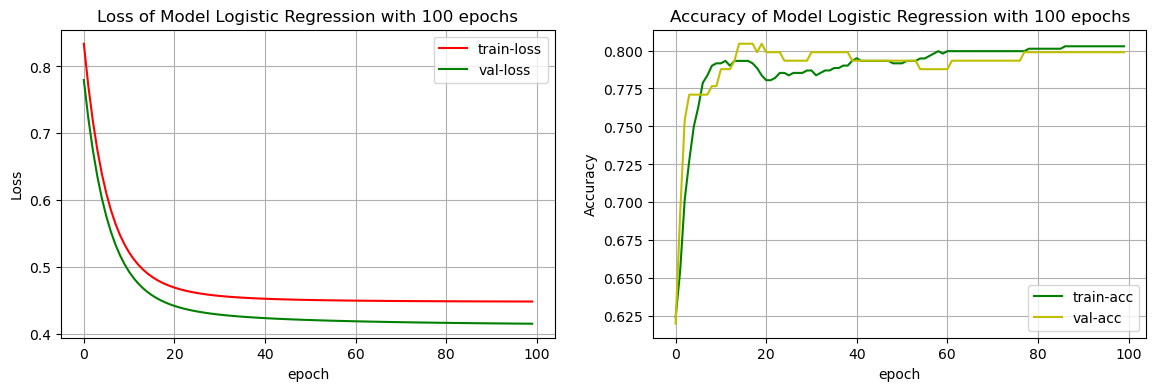

In [82]:
plt.subplots(1,2,figsize = (14,4))
plt.subplot(1,2,1)
plt.title(f"Loss of Model Logistic Regression with {clf.n_epochs} epochs")
plt.plot(clf.train_Losses,'r',label = 'train-loss')
plt.plot(clf.val_Losses,'g',label = 'val-loss')
plt.grid()
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.title(f"Accuracy of Model Logistic Regression with {clf.n_epochs} epochs")
plt.plot(clf.train_accuracies,'g',label = 'train-acc')
plt.plot(clf.val_accuracies,'y',label = 'val-acc')
plt.grid()
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.legend()

In [83]:
# Đánh giá mô hình train tập test
y_pred = clf.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87        53
           1       0.82      0.78      0.80        36

    accuracy                           0.84        89
   macro avg       0.84      0.83      0.84        89
weighted avg       0.84      0.84      0.84        89

